In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import shuffle

In [20]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications.imagenet_utils import preprocess_input

In [21]:
from SSD300 import SSD300v2
from SSD_utils import BBoxUtility
from SSD_loss import MultiboxLoss

## **some constants**

In [22]:
NUM_CLASSES = 6
input_shape = (300, 300, 3)

# **Read TFRecord**

In [23]:
train_raw_image_dataset = tf.data.TFRecordDataset('train_images.tfrecords')
image_feature_description = {
    'filename': tf.io.FixedLenFeature([], tf.string),
    'image_raw': tf.io.FixedLenFeature([], tf.string)}

def _parse_image_function(example_proto):
  return tf.io.parse_single_example(example_proto, image_feature_description)

train_image_dataset = train_raw_image_dataset.map(_parse_image_function)
train_image_dataset

<MapDataset shapes: {filename: (), image_raw: ()}, types: {filename: tf.string, image_raw: tf.string}>

In [24]:
def resize_image300(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [300, 300])
  image /= 255.0  # normalize to [0,1] range

  return image

In [25]:
train_image_filenames = []
train_images = {}

for data in train_image_dataset:
  name = data['filename'].numpy().decode()
  image = resize_image300(data['image_raw'])
  train_image_filenames.append(name)
  train_images[name] = np.array(image)

print(train_image_filenames)
print(len(train_image_filenames))

print(len(train_images))
print(train_images['IMG_3870.JPG'])

['IMG_3870.JPG', 'IMG_3883.JPG', 'IMG_3878.JPG', 'IMG_3885.JPG', 'IMG_3866.JPG', 'IMG_3863.JPG', 'IMG_3886.JPG', 'IMG_3855.JPG', 'IMG_3877.JPG', 'IMG_3860.JPG', 'IMG_3893.JPG', 'IMG_3899.JPG', 'IMG_3869.JPG', 'IMG_3894.JPG', 'IMG_3873.JPG', 'IMG_3880.JPG', 'IMG_3901.JPG', 'IMG_3787.JPG', 'IMG_3890.JPG', 'IMG_3854.JPG', 'IMG_3857.JPG', 'IMG_3889.JPG', 'IMG_3902.JPG', 'IMG_3868.JPG', 'IMG_3862.JPG', 'IMG_3900.JPG', 'IMG_3867.JPG', 'IMG_3858.JPG', 'IMG_3872.JPG', 'IMG_3757.JPG', 'IMG_3876.JPG', 'IMG_3871.JPG', 'IMG_3856.JPG', 'IMG_3897.JPG', 'IMG_3882.JPG', 'IMG_3895.JPG', 'IMG_3892.JPG', 'IMG_3865.JPG', 'IMG_3891.JPG', 'IMG_3884.JPG', 'IMG_3859.JPG', 'IMG_3896.JPG', 'IMG_3736.JPG', 'IMG_3864.JPG', 'IMG_3881.JPG', 'IMG_3888.JPG', 'IMG_3898.JPG', 'IMG_3874.JPG', 'IMG_3879.JPG', 'IMG_3861.JPG', 'IMG_3887.JPG', 'IMG_3875.JPG']
52
52
[[[0.20369098 0.22722039 0.22722039]
  [0.21946509 0.24299452 0.24299452]
  [0.18869019 0.2122196  0.20516077]
  ...
  [0.02758414 0.02758414 0.019741  ]
  [0.02

<class 'dict'>
<class 'numpy.ndarray'>


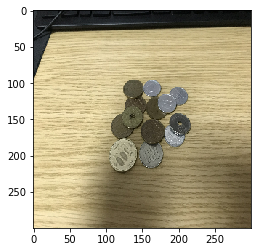

In [26]:
print(type(train_images))
plt.imshow(train_images['IMG_3870.JPG'])
print(type(train_images['IMG_3870.JPG']))

# **Read csv**

In [27]:
train_csv = pd.read_csv('train_labels_300.csv')
train_csv = train_csv.set_index('filename')

# [[xmin, ymin, xmax, ymax, 0.1, 0.1, 0.2, 0.2], ....] 0.1, 0.2 -> variances
# Use this BBoxutile
train_boxes_list = []

# Use this Generator
train_boxes_label_dict =  {}
# One hot vector for class_name
one_hot_vector = {'1en': [1, 0, 0, 0, 0, 0],
                  '5en': [0, 1, 0, 0, 0, 0],
                  '10en': [0, 0, 1, 0, 0, 0],
                  '50en': [0, 0, 0, 1, 0, 0],
                  '100en': [0, 0, 0, 0, 1, 0],
                  '500en': [0, 0, 0, 0, 0, 1]}

for key in train_image_filenames:
  class_name = [i for i in train_csv[key:key]['class']]
  xmin = [i for i in train_csv[key:key]['xmin']]
  ymin = [i for i in train_csv[key:key]['ymin']]
  xmax = [i for i in train_csv[key:key]['xmax']]
  ymax = [i for i in train_csv[key:key]['ymax']]

  value = []
  for i in range(len(class_name)):
    tmp = []
    tmp_box_label = []
    priorbox_variances = [0.1, 0.1, 0.2, 0.2]
    tmp.extend([xmin[i], ymin[i], xmax[i], ymax[i]])
    tmp_box_label.extend([xmin[i], ymin[i], xmax[i], ymax[i]])
    # Processing for train_boxes_label_dict
    class_name_one_hot = one_hot_vector[class_name[i]]
    tmp_box_label.extend(class_name_one_hot)
    value.append(tmp_box_label)

    # Processing for train_boxes_list
    tmp.extend(priorbox_variances)
    train_boxes_list.append(tmp)

  train_boxes_label_dict[key] = np.array(value)

train_boxes_list = np.array(train_boxes_list)
print(train_boxes_list[0])
print(type(train_boxes_list))
print(train_boxes_label_dict.keys())
print(train_boxes_label_dict['IMG_3870.JPG'])


[1.516e+02 9.440e+01 1.766e+02 1.206e+02 1.000e-01 1.000e-01 2.000e-01
 2.000e-01]
<class 'numpy.ndarray'>
dict_keys(['IMG_3870.JPG', 'IMG_3883.JPG', 'IMG_3878.JPG', 'IMG_3885.JPG', 'IMG_3866.JPG', 'IMG_3863.JPG', 'IMG_3886.JPG', 'IMG_3855.JPG', 'IMG_3877.JPG', 'IMG_3860.JPG', 'IMG_3893.JPG', 'IMG_3899.JPG', 'IMG_3869.JPG', 'IMG_3894.JPG', 'IMG_3873.JPG', 'IMG_3880.JPG', 'IMG_3901.JPG', 'IMG_3787.JPG', 'IMG_3890.JPG', 'IMG_3854.JPG', 'IMG_3857.JPG', 'IMG_3889.JPG', 'IMG_3902.JPG', 'IMG_3868.JPG', 'IMG_3862.JPG', 'IMG_3900.JPG', 'IMG_3867.JPG', 'IMG_3858.JPG', 'IMG_3872.JPG', 'IMG_3757.JPG', 'IMG_3876.JPG', 'IMG_3871.JPG', 'IMG_3856.JPG', 'IMG_3897.JPG', 'IMG_3882.JPG', 'IMG_3895.JPG', 'IMG_3892.JPG', 'IMG_3865.JPG', 'IMG_3891.JPG', 'IMG_3884.JPG', 'IMG_3859.JPG', 'IMG_3896.JPG', 'IMG_3736.JPG', 'IMG_3864.JPG', 'IMG_3881.JPG', 'IMG_3888.JPG', 'IMG_3898.JPG', 'IMG_3874.JPG', 'IMG_3879.JPG', 'IMG_3861.JPG', 'IMG_3887.JPG', 'IMG_3875.JPG'])
[[151.6  94.4 176.6 120.6   1.    0.    0.    0. 

In [28]:
bbox_util = BBoxUtility(NUM_CLASSES, train_boxes_list)

In [29]:
num_train = int(round(0.8 * len(train_image_filenames)))
train_keys = train_image_filenames[:num_train]
val_keys = train_image_filenames[num_train:]
num_val = len(val_keys)

print(train_keys)
print(val_keys)

['IMG_3870.JPG', 'IMG_3883.JPG', 'IMG_3878.JPG', 'IMG_3885.JPG', 'IMG_3866.JPG', 'IMG_3863.JPG', 'IMG_3886.JPG', 'IMG_3855.JPG', 'IMG_3877.JPG', 'IMG_3860.JPG', 'IMG_3893.JPG', 'IMG_3899.JPG', 'IMG_3869.JPG', 'IMG_3894.JPG', 'IMG_3873.JPG', 'IMG_3880.JPG', 'IMG_3901.JPG', 'IMG_3787.JPG', 'IMG_3890.JPG', 'IMG_3854.JPG', 'IMG_3857.JPG', 'IMG_3889.JPG', 'IMG_3902.JPG', 'IMG_3868.JPG', 'IMG_3862.JPG', 'IMG_3900.JPG', 'IMG_3867.JPG', 'IMG_3858.JPG', 'IMG_3872.JPG', 'IMG_3757.JPG', 'IMG_3876.JPG', 'IMG_3871.JPG', 'IMG_3856.JPG', 'IMG_3897.JPG', 'IMG_3882.JPG', 'IMG_3895.JPG', 'IMG_3892.JPG', 'IMG_3865.JPG', 'IMG_3891.JPG', 'IMG_3884.JPG', 'IMG_3859.JPG', 'IMG_3896.JPG']
['IMG_3736.JPG', 'IMG_3864.JPG', 'IMG_3881.JPG', 'IMG_3888.JPG', 'IMG_3898.JPG', 'IMG_3874.JPG', 'IMG_3879.JPG', 'IMG_3861.JPG', 'IMG_3887.JPG', 'IMG_3875.JPG']


In [30]:
class Generator(object):
  def __init__(self, batch_size, bbox_util, 
               train_image_filenames, train_images, 
               train_boxes_label_dict,
               image_size,
               saturation_var=0.5,
               brightness_var=0.5,
               contrast_var=0.5,
               lighting_std=0.5,
               hflip_prob=0.5,
               vflip_prob=0.5,
               do_crop=True,
               crop_area_range=[0.75, 1.0],
               aspect_ratio_range=[3./4., 4./3.]):
    self.batch_size = batch_size
    self.bbox_util = bbox_util
    self.train_image_filenames = train_image_filenames
    self.train_images = train_images
    self.train_boxes_label_dict = train_boxes_label_dict
    self.num_train = int(round(0.8 * len(train_image_filenames)))
    self.train_keys = train_image_filenames[:num_train]
    self.val_keys = train_image_filenames[num_train:]
    self.num_val = len(val_keys)
    self.train_batches = len(self.train_keys)
    self.val_batches = len(self.val_keys)

    self.image_size = image_size
    self.color_jitter = []
    if saturation_var:
      self.saturation_var = saturation_var
      self.color_jitter.append(self.saturation)
    if brightness_var:
      self.brightness_var = brightness_var
      self.color_jitter.append(self.brightness)
    if contrast_var:
      self.contrast_var = contrast_var
      self.color_jitter.append(self.contrast)
    self.lighting_std = lighting_std
    self.hflip_prob = hflip_prob
    self.vflip_prob = vflip_prob
    self.do_crop = do_crop
    self.crop_area_range = crop_area_range
    self.aspect_ratio_range = aspect_ratio_range

  def grayscale(self, rgb):
    return rgb.dot([0.299, 0.587, 0.114])

  def saturation(self, rgb):
    gs = self.grayscale(rgb)
    alpha = 2 * np.random.random() * self.saturation_var 
    alpha += 1 - self.saturation_var
    rgb = rgb * alpha + (1 - alpha) * gs[:, :, None]
    return np.clip(rgb, 0, 255)

  def brightness(self, rgb):
    alpha = 2 * np.random.random() * self.brightness_var 
    alpha += 1 - self.saturation_var
    rgb = rgb * alpha
    return np.clip(rgb, 0, 255)

  def contrast(self, rgb):
    gs = self.grayscale(rgb).mean() * np.ones_like(rgb)
    alpha = 2 * np.random.random() * self.contrast_var 
    alpha += 1 - self.contrast_var
    rgb = rgb * alpha + (1 - alpha) * gs
    return np.clip(rgb, 0, 255)

  def lighting(self, img):
    cov = np.cov(img.reshape(-1, 3) / 255.0, rowvar=False)
    eigval, eigvec = np.linalg.eigh(cov)
    noise = np.random.randn(3) * self.lighting_std
    noise = eigvec.dot(eigval * noise) * 255
    img += noise
    return np.clip(img, 0, 255)
    
  def horizontal_flip(self, img, y):
    if np.random.random() < self.hflip_prob:
        img = img[:, ::-1]
        y[:, [0, 2]] = 1 - y[:, [2, 0]]
    return img, y
    
  def vertical_flip(self, img, y):
    if np.random.random() < self.vflip_prob:
        img = img[::-1]
        y[:, [1, 3]] = 1 - y[:, [3, 1]]
    return img, y
    
  def random_sized_crop(self, img, targets):
    img_w = img.shape[1]
    img_h = img.shape[0]
    img_area = img_w * img_h
    random_scale = np.random.random()
    random_scale *= (self.crop_area_range[1] -
                     self.crop_area_range[0])
    random_scale += self.crop_area_range[0]
    target_area = random_scale * img_area
    random_ratio = np.random.random()
    random_ratio *= (self.aspect_ratio_range[1] -
                     self.aspect_ratio_range[0])
    random_ratio += self.aspect_ratio_range[0]
    w = np.round(np.sqrt(target_area * random_ratio))     
    h = np.round(np.sqrt(target_area / random_ratio))
    if np.random.random() < 0.5:
        w, h = h, w
    w = min(w, img_w)
    w_rel = w / img_w
    w = int(w)
    h = min(h, img_h)
    h_rel = h / img_h
    h = int(h)
    x = np.random.random() * (img_w - w)
    x_rel = x / img_w
    x = int(x)
    y = np.random.random() * (img_h - h)
    y_rel = y / img_h
    y = int(y)
    img = img[y:y+h, x:x+w]
    new_targets = []
    for box in targets:
        cx = 0.5 * (box[0] + box[2])
        cy = 0.5 * (box[1] + box[3])
        if (x_rel < cx < x_rel + w_rel and
            y_rel < cy < y_rel + h_rel):
            xmin = (box[0] - x_rel) / w_rel
            ymin = (box[1] - y_rel) / h_rel
            xmax = (box[2] - x_rel) / w_rel
            ymax = (box[3] - y_rel) / h_rel
            xmin = max(0, xmin)
            ymin = max(0, ymin)
            xmax = min(1, xmax)
            ymax = min(1, ymax)
            box[:4] = [xmin, ymin, xmax, ymax]
            new_targets.append(box)
    new_targets = np.asarray(new_targets).reshape(-1, targets.shape[1])
    return img, new_targets
    
  def generate(self, train=True):
    while True:
      if train:
        keys = self.train_keys
      else:
        keys = self.val_keys
      inputs = []
      targets = []
      for key in keys:
        img = tf.cast(self.train_images[key], tf.float32)
        y = self.train_boxes_label_dict[key]
        if train and self.do_crop:
          img, y = self.random_sized_crop(img, y)
        img = tf.cast(tf.image.resize(img, self.image_size), tf.float32)
        if train:
          shuffle(self.color_jitter)
          for jitter in self.color_jitter:
            img = jitter(img)
          if self.lighting_std:
            img = self.lighting(img)
          if self.hflip_prob > 0:
            img, y = self.horizontal_flip(img, y)
          if self.vflip_prob > 0:
            img, y = self.vertical_flip(img, y)
        y = self.bbox_util.assign_boxes(y)
        inputs.append(img)
        targets.append(targets)
        if len(targets) == self.batch_size:
          tmp_inp = np.array(inputs)
          tmp_targets = np.array(targets)
          inputs = []
          targets = []
          yield preprocess_input(tmp_inp), tmp_targets


In [31]:
gen = Generator(4, bbox_util, train_image_filenames, train_images, train_boxes_label_dict, (input_shape[0],       input_shape[1]), do_crop=False)

In [32]:
model = SSD300v2(input_shape, num_classes=NUM_CLASSES)

(None, 17328) conv4_3_norm_mbox_loc_flat
(None, 25992) conv4_3_norm_mbox_conf_flat
Tensor("conv4_3_norm_mbox_priorbox_1/Identity:0", shape=(None, 58368, 8), dtype=float32) conv4_3_norm_mbox_priorbox
7308 num_boxes
(None, 29232) mbox_loc
(None, 43848) mbox_conf
Tensor("mbox_loc_final_1/Identity:0", shape=(None, 7308, 4), dtype=float32) locatation
Tensor("mbox_conf_final_1/Identity:0", shape=(None, 7308, 6), dtype=float32) conf
Tensor("mbox_priorbox_final_1/Identity:0", shape=(None, 7308, 4), dtype=float32) priorbox
(None, 7308, 14) predictions
Tensor("predictions_1/Identity:0", shape=(None, 7308, 14), dtype=float32) predictions


In [33]:
freeze = ['input_1', 'conv1_1', 'conv1_2', 'pool1',
          'conv2_1', 'conv2_2', 'pool2',
          'conv3_1', 'conv3_2', 'conv3_3', 'pool3']#,
#           'conv4_1', 'conv4_2', 'conv4_3', 'pool4']

for L in model.layers:
    if L.name in freeze:
        L.trainable = False

In [34]:
def schedule(epoch, decay=0.9):
    return base_lr * decay**(epoch)

callbacks = [keras.callbacks.ModelCheckpoint('./checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
                                             verbose=1,
                                             save_weights_only=True),
             keras.callbacks.LearningRateScheduler(schedule)]

In [35]:
base_lr = 3e-4
optim = keras.optimizers.Adam(lr=base_lr)
# optim = keras.optimizers.RMSprop(lr=base_lr)
# optim = keras.optimizers.SGD(lr=base_lr, momentum=0.9, decay=decay, nesterov=True)
model.compile(optimizer=optim,
              loss=MultiboxLoss(NUM_CLASSES, neg_pos_ratio=2.0).compute_loss)

In [36]:
nb_epoch = 30
history = model.fit_generator(gen.generate(True), gen.train_batches,
                              nb_epoch, verbose=1,
                              callbacks=callbacks,
                              validation_data=gen.generate(False),
                              validation_steps=gen.val_batches)

Epoch 1/30


NameError: name 'shuffle' is not defined